# 0. Libarary 불러오기 및 경로설정

In [1]:
import os
from glob import glob
import pandas as pd
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize

## GPU 설정

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

---

# Dataset 구조 파악

```bash
├── 📁code
│   ├── requirements.txt
│   ├── sample_submission.ipynb
│   └── practice.ipynb (개인 파일)
│
└── 📁input
    └── 📁data
         ├── 📁train
         │   ├── 📁images ( 2700 folder * image 7 개 = 18900 개 image)
         │   │    ├── 📁000001_female_Asian_45
         │   │    ├── ... (total folder 갯수 : 2700 개 (숨김 파일 제외) -> 2700 명)
         │   │    └── 📁006959_male_Asian_19
         │   │         │  * 폴더 내의 파일 내용은 sample 5 개 수기로 확인해본 결과 + 파일 확장자 (jpg, jpeg, png 존재)
         │   │         │
         │   │         ├── incorrect_mask.jpg (부정확한 마스크 (코 미착용))
         │   │         ├── mask1.jpg (KF 94 두꺼운 흰 마스크)
         │   │         ├── mask2.jpg (파란 마스크)
         │   │         ├── mask3.jpg (얇은 덴탈 흰 마스크)
         │   │         ├── mask4.jpg (분홍색 마스크)
         │   │         ├── mask5.jpg (검은색 마스크, 줄무늬 마스크 등 독특한 마스크)
         │   │         └── normal.jpg (mask 미착용)
         │   │
         │   └── train.csv
         │
         │
         └── 📁eval
             ├── 📁images
             │    ├── fffde6a740sdakfnn41nf.jpg
             │    ├── ...
             │    │   * total image 갯수 : 12600 개 (숨김 파일 제외) (인 당 사진의 갯수가 7개 이므로 1800 명)
             │    └── ff44e2a7775s2akfn41nc.jpg
             │
             └── info.csv

``` 

In [3]:
os.getcwd()

'/opt/ml/code'

In [4]:
print('train 전체 파일 수 : ', len( os.listdir('../input/data/train/images/')))
print('train 숨김 파일 제외한 파일 수 : ', len([path for path in os.listdir('../input/data/train/images/') if '.' not in path]))

train 전체 파일 수 :  5400
train 숨김 파일 제외한 파일 수 :  2700


In [5]:
print('eval 전체 파일 수 : ', len(os.listdir('../input/data/eval/images')))
print('eval 숨김 파일 제외한 파일 수 : ', len([path for path in os.listdir('../input/data/eval/images') if '.' not in path[:-4]]))

eval 전체 파일 수 :  25201
eval 숨김 파일 제외한 파일 수 :  12600


In [6]:
TRAIN_DIR = '/opt/ml/input/data/train' 
TEST_DIR = '/opt/ml/input/data/eval'

---

## EDA

### Train CSV 파일 확인
- Column : id / gender / race / age / path
    - Gender : female / male
    - Race : Asian
    - Age : 18 - 60
    - Path : {id}\_{gender}\_{race}\_{age}
- row : 2700 개 (directory path 를 의미하며, 각 directory 마다 7개의 사진이 들어있다)
- 결측치 갯수 : 0 개

In [7]:
df_train = pd.read_csv(TRAIN_DIR + '/train.csv')

In [8]:
df_train.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


In [9]:
print('Row 갯수 : ', len(df_train))
print('결측치 갯수 : ', df_train.isnull().sum().sum())
print('gender Feature : ', df_train['gender'].unique())
print('race Feature : ', df_train['race'].unique())
print('Age : ', df_train['age'].sort_values().unique())

Row 갯수 :  2700
결측치 갯수 :  0
gender Feature :  ['female' 'male']
race Feature :  ['Asian']
Age :  [18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60]


### Image 파일 확인
- 학습 image 갯수 : 18900 개 (2700 개 directroy * 7 개의 사진)
- Image shape : (512, 384, 3)

In [10]:
train_paths = glob(TRAIN_DIR + '/images/*/*')

In [11]:
train_paths[:5]

['/opt/ml/input/data/train/images/006259_female_Asian_20/mask5.jpg',
 '/opt/ml/input/data/train/images/006259_female_Asian_20/mask2.jpg',
 '/opt/ml/input/data/train/images/006259_female_Asian_20/mask4.jpg',
 '/opt/ml/input/data/train/images/006259_female_Asian_20/incorrect_mask.jpg',
 '/opt/ml/input/data/train/images/006259_female_Asian_20/mask1.jpg']

- 2700 개 directroy * 7 개의 사진 = 18900

In [12]:
len(train_paths)

18900

- 파일 확장자는 jpg, jpeg, png 가 존재

In [13]:
set([path[-4:] for path in train_paths])

{'.jpg', '.png', 'jpeg'}

### Sample Image 확인

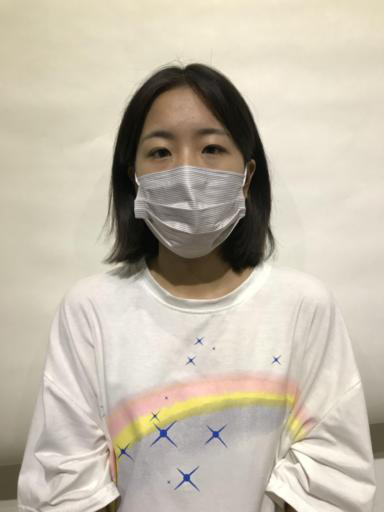

In [14]:
sample_image = Image.open(train_paths[0])
sample_image

- image shape : (512, 384, 3)

In [15]:
image_array = np.array(sample_image)
image_array.shape

(512, 384, 3)

### 모든 Image shape 동일 여부 확인

In [16]:
widths = []
heights = []

for path in tqdm(train_paths):
    image = Image.open(path)
    image_array = np.array(image)
    w, h, _ = image_array.shape
    
    widths.append(w)
    heights.append(h)

100%|██████████| 18900/18900 [01:02<00:00, 303.92it/s]


In [17]:
print('Width : ', np.unique(widths, return_counts=True))
print('Height : ', np.unique(heights, return_counts=True))

Width :  (array([512]), array([18900]))
Height :  (array([384]), array([18900]))


- 모든 이미지가 동일한 shape 인 (512, 384) 를 갖는 것 확인 가능

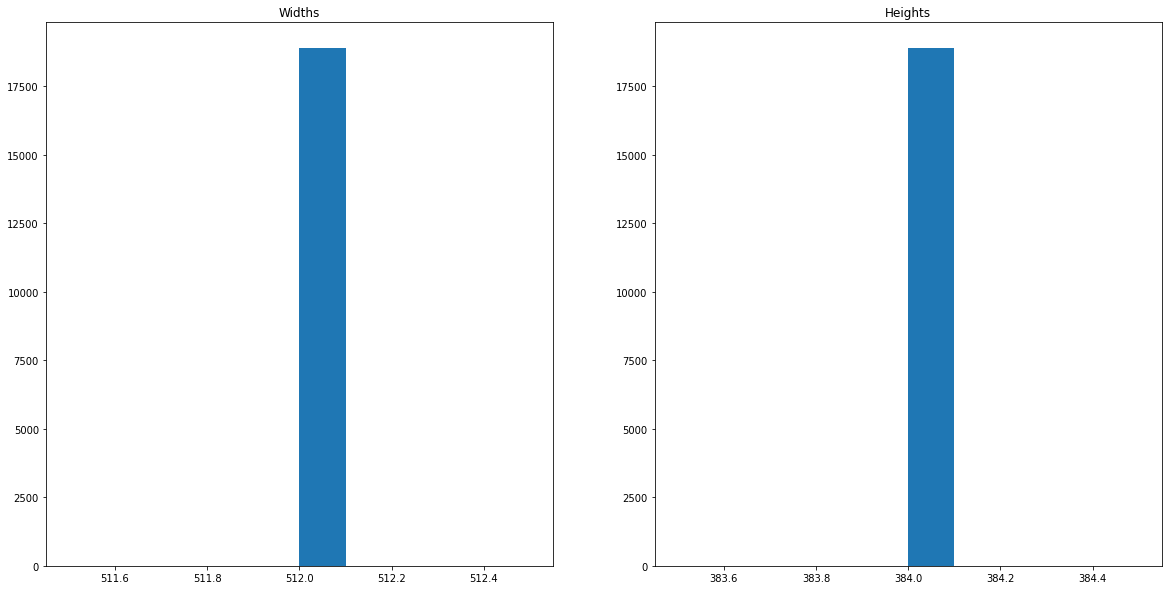

In [18]:
plt.figure(figsize=(20, 10))

plt.subplot(121)
plt.title('Widths')
plt.hist(widths)

plt.subplot(122)
plt.title('Heights')
plt.hist(heights)

plt.show()

---

# DataSet 만들기

## Label (class) 가져오기

In [19]:
def classify_class(mask, gender, age):
    '''
        Mask, Gender, Age 를 입력 받아 class 를 return 하는 함수
        class 는 0 - 17 으로 총 18 개의 class 존재
    '''
    
    if mask[:4] == 'mask':   # Mask feature 가 'Wear' 인 경우 (mask = mask1, mask2, mask3, mask4, mask5)
        if gender == 'male':   # Gender feature 가 'Male' 인 경우
            if age < 30:   # Age feature 가 age < 30 인 경우
                label = 0
            elif age >= 30 and age < 60:   # Age feature 가 30 <= age < 60 인 경우
                label = 1
            else:   # Age feature 가 age > 60 인 경우
                label = 2
        else:   # Gender featrue 가 'Female' 인 경우
            if age < 30:   # Age feature 가 age < 30 인 경우
                label = 3
            elif age >= 30 and age < 60:   # Age feature 가 30 <= age < 60 인 경우
                label = 4
            else:   # Age feature 가 age > 60 인 경우
                label = 5
    elif mask == 'incorrect_mask':   # Mask feature 가 'Incorrect' 인 경우 (mask = incorrect_mask)
        if gender == 'male':   # Gender feature 가 'Male' 인 경우
            if age < 30:   # Age feature 가 age < 30 인 경우
                label = 6
            elif age >= 30 and age < 60:   # Age feature 가 30 <= age < 60 인 경우
                label = 7
            else:   # Age feature 가 age > 60 인 경우
                label = 8
        else:   # Gender featrue 가 'Female' 인 경우
            if age < 30:   # Age feature 가 age < 30 인 경우
                label = 9
            elif age >= 30 and age < 60:   # Age feature 가 30 <= age < 60 인 경우
                label = 10
            else:   # Age feature 가 age > 60 인 경우
                label = 11
    else:   # Mask feature 가 'Not Wear' 인 경우 (mask = normal)
        if gender == 'male':   # Gender feature 가 'Male' 인 경우
            if age < 30:   # Age feature 가 age < 30 인 경우
                label = 12
            elif age >= 30 and age < 60:   # Age feature 가 30 <= age < 60 인 경우
                label = 13
            else:   # Age feature 가 age > 60 인 경우
                label = 14
        else:   # Gender featrue 가 'Female' 인 경우
            if age < 30:   # Age feature 가 age < 30 인 경우
                label = 15
            elif age >= 30 and age < 60:   # Age feature 가 30 <= age < 60 인 경우
                label = 16
            else:   # Age feature 가 age > 60 인 경우
                label = 17
    
    return label

In [20]:
def get_label(path):
    '''
        path 를 입력으로 받아 label (class) 를 return 하는 함수
        
        : class 를 구분하는 기준으로는 Mask, Gender, Age 가 존재
    '''
    
    _, gender, _, age = path.split('/')[-2].split('_')   # id_gender_race_age 를 '_' 로 split
    mask = path.split('/')[-1].split('.')[0]   # mask5.jpg 와 같은 파일명에서 확장자를 제거
    label = classify_class(mask, gender, int(age))   # classify_class 함수로 부터 label 을 반환
    
    return label

In [21]:
for path in train_paths[10:15]:
    print('path: ', path)
    print('label: ', get_label(path))
    print('-------------------------' * 3)
    print()

path:  /opt/ml/input/data/train/images/003643_male_Asian_58/incorrect_mask.jpg
label:  7
---------------------------------------------------------------------------

path:  /opt/ml/input/data/train/images/003643_male_Asian_58/mask1.jpg
label:  1
---------------------------------------------------------------------------

path:  /opt/ml/input/data/train/images/003643_male_Asian_58/normal.jpg
label:  13
---------------------------------------------------------------------------

path:  /opt/ml/input/data/train/images/003643_male_Asian_58/mask3.jpg
label:  1
---------------------------------------------------------------------------

path:  /opt/ml/input/data/train/images/001233_male_Asian_25/mask5.jpg
label:  0
---------------------------------------------------------------------------



### Example

In [22]:
train_paths[0]

'/opt/ml/input/data/train/images/006259_female_Asian_20/mask5.jpg'

In [23]:
id_gender_race_age = train_paths[0].split('/')[-2]
file_name = train_paths[0].split('/')[-1]

In [26]:
id_gender_race_age, file_name

('006259_female_Asian_20', 'mask5.jpg')

In [27]:
_, gender, _, age = id_gender_race_age.split('_')

In [28]:
gender, age

('female', '20')

In [29]:
file_name.split('.')[0][:4] == 'mask'

True

## Custom Dataset

In [31]:
class CustomDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        path = self.img_paths[index]
        image = Image.open(path)

        if self.transform:
            image = self.transform(image)
        
        # get label
        label = get_label(path)
        
        return image, label

    def __len__(self):
        return len(self.img_paths)

## DataLoader

In [32]:
# batch_size 지정
batch_size = 32

# device cuda 설정
kwargs = {'num_workers': 1, 'pin_memory': True}

# train_loader
train_loader = torch.utils.data.DataLoader(
  CustomDataset(train_paths,
         transforms.Compose([
           transforms.RandomHorizontalFlip(),
           transforms.ToTensor(),
           ])),
  batch_size=batch_size,
  shuffle=True,
  **kwargs
)

In [33]:
# images, labels에 첫번째 데이터 저장
images, labels = next(iter(train_loader))

In [34]:
images.shape

torch.Size([32, 3, 512, 384])

In [35]:
labels.shape

torch.Size([32])

---

# Model

In [36]:
class MyModel(nn.Module):
    def __init__(self, num_classes: int = 18):
        super(MyModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

---

# Training

In [37]:
seed = 42

torch.manual_seed(seed)

In [39]:
model = MyModel().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
# HyperParameter Settings
epochs = 100 # 에포크 횟수
log_interval = 100 # 로그를 보기위한 간격


# Training
for epoch in range(1, epochs + 1):
  # Train Mode
  model.train()
    
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    
    if batch_idx % log_interval == 0:
      print('Train_Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
      	epoch, batch_idx * len(data), len(train_loader.dataset),
      	100 * batch_idx / len(train_loader), loss.item()
      ))

Train_Epoch: 1 [0/18900 (0%)]	Loss: 2.944119
Train_Epoch: 1 [3200/18900 (17%)]	Loss: 2.211838
Train_Epoch: 1 [6400/18900 (34%)]	Loss: 2.346644
Train_Epoch: 1 [9600/18900 (51%)]	Loss: 2.149448
Train_Epoch: 1 [12800/18900 (68%)]	Loss: 2.146132
Train_Epoch: 1 [16000/18900 (85%)]	Loss: 2.433481
Train_Epoch: 2 [0/18900 (0%)]	Loss: 2.422687
Train_Epoch: 2 [3200/18900 (17%)]	Loss: 2.357340
Train_Epoch: 2 [6400/18900 (34%)]	Loss: 2.043781
Train_Epoch: 2 [9600/18900 (51%)]	Loss: 2.180921
Train_Epoch: 2 [12800/18900 (68%)]	Loss: 2.090454
Train_Epoch: 2 [16000/18900 (85%)]	Loss: 2.032317
Train_Epoch: 3 [0/18900 (0%)]	Loss: 2.375171
Train_Epoch: 3 [3200/18900 (17%)]	Loss: 2.260056
Train_Epoch: 3 [6400/18900 (34%)]	Loss: 2.127870
Train_Epoch: 3 [9600/18900 (51%)]	Loss: 2.591984
Train_Epoch: 3 [12800/18900 (68%)]	Loss: 1.948342
Train_Epoch: 3 [16000/18900 (85%)]	Loss: 2.394518
Train_Epoch: 4 [0/18900 (0%)]	Loss: 2.001086
Train_Epoch: 4 [3200/18900 (17%)]	Loss: 2.190991
Train_Epoch: 4 [6400/18900 (34